In [56]:
# Import dependencies
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from joblib import dump

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd

import seaborn as sns 
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

import nltk

In [57]:
# Read in CSV File
raw_data=pd.read_csv('db/wine_library.csv', dtype={'Zip': 'str'})
raw_data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez


In [58]:
raw_data["country"].unique()

array(['US', 'Spain', 'France', 'Italy', 'New Zealand', 'Bulgaria',
       'Argentina', 'Australia', 'Portugal', 'Israel', 'South Africa',
       'Greece', 'Chile', 'Morocco', 'Romania', 'Germany', 'Canada',
       'Moldova', 'Hungary', 'Austria', 'Croatia', 'Slovenia', nan,
       'India', 'Turkey', 'Macedonia', 'Lebanon', 'Serbia', 'Uruguay',
       'Switzerland', 'Albania', 'Bosnia and Herzegovina', 'Brazil',
       'Cyprus', 'Lithuania', 'Japan', 'China', 'South Korea', 'Ukraine',
       'England', 'Mexico', 'Georgia', 'Montenegro', 'Luxembourg',
       'Slovakia', 'Czech Republic', 'Egypt', 'Tunisia', 'US-France'],
      dtype=object)

In [77]:
# Drop the columns and NaN values in it
# NOTE: Only dropping NaN values from country and price. If I dropped NaN values from region_2 then I only have 9 
# countries, losing too much data.

dropped_data = raw_data.drop(['designation', 'Unnamed: 0'], axis = 1) 
wine_data = dropped_data.dropna(subset=['price', 'country'])
wine_data.head(3)
# dropped_data["country"].unique()
wine_data["country"].unique()

array(['US', 'Spain', 'France', 'Italy', 'New Zealand', 'Bulgaria',
       'Argentina', 'Australia', 'Portugal', 'Israel', 'South Africa',
       'Greece', 'Chile', 'Morocco', 'Romania', 'Germany', 'Canada',
       'Moldova', 'Hungary', 'Austria', 'Croatia', 'Slovenia', 'India',
       'Turkey', 'Macedonia', 'Lebanon', 'Serbia', 'Uruguay',
       'Switzerland', 'Albania', 'Bosnia and Herzegovina', 'Brazil',
       'Cyprus', 'Lithuania', 'Japan', 'China', 'South Korea', 'Ukraine',
       'England', 'Mexico', 'Georgia', 'Montenegro', 'Luxembourg',
       'Slovakia', 'Czech Republic', 'US-France'], dtype=object)

# Prepare the data for ML - clean description 

In [60]:
# set seaborn style 
sns.set(style="whitegrid")

In [61]:
stopwords = set(stopwords.words('english'))
detokenizer = TreebankWordDetokenizer()

In [62]:
# Create a fucntion that would clean description column
def clean_description(desc):
    
# convert to lower cases
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)

In [63]:
# Use apply method to create cleaned description column
wine_data["cleaned_description"] = wine_data["description"].apply(clean_description)
wine_data.head(2)

/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,country,description,points,price,province,region_1,region_2,variety,winery,cleaned_description
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hails oakville aged t...
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas fig blackberry cassis softened swe...


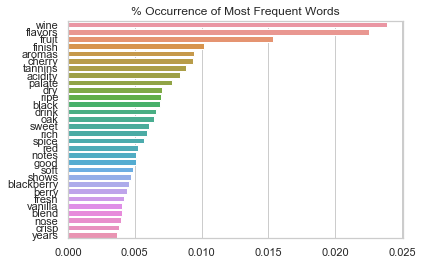

In [64]:
# Plot for the most frequent words occurence
word_occurrence = wine_data["cleaned_description"].str.split(expand=True).stack().value_counts()
total_words = sum(word_occurrence)

# plot most common words 
top_words = word_occurrence[:30]/total_words

# assign x and y on the plot
ax = sns.barplot(x = top_words.values, y = top_words.index)

# Setting the title to the graoh
ax.set_title("% Occurrence of Most Frequent Words")

plt.show()

# Prepare the data for ML - Map the reviews by points into classes

In [65]:
# defining function to get the points into buckets 
# NOTE: refer to this article (classification) https://www.winemag.com/2019/01/02/wine-vintage-chart-2019/
def buckets(points):
    if points in range(80,85): 
        return 4
    elif points in range(85,90):
        return 3
    elif points in range(90,95):
        return 2
    else:
        return 1

# Apply method to get an additional column with points in the buckets => labels
wine_data["labels"] = wine_data["points"].apply(buckets)
wine_data.head(100)

/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,country,description,points,price,province,region_1,region_2,variety,winery,cleaned_description,labels
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hails oakville aged t...,1
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas fig blackberry cassis softened swe...,1
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,mac watson honors memory wine made mother trem...,1
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,spent months new french oak incorporates fruit...,1
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,top wine la bégude named highest point vineyar...,1
5,Spain,"Deep, dense and pure from the opening bell, th...",95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia,deep dense pure opening bell toro winner aroma...,1
6,Spain,Slightly gritty black-fruit aromas include a s...,95,65.0,Northern Spain,Toro,NaN,Tinta de Toro,Maurodos,slightly gritty aromas include sweet note past...,1
7,Spain,Lush cedary black-fruit aromas are luxe and of...,95,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,lush cedary aromas luxe offer notes marzipan v...,1
8,US,This re-named vineyard was formerly bottled as...,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,vineyard formerly bottled delancellotti find s...,1
9,US,The producer sources from two blocks of the vi...,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,producer sources two blocks vineyard high elev...,1


In [66]:
# Verify data is of correct type
wine_data.dtypes

country                 object
description             object
points                   int64
price                  float64
province                object
region_1                object
region_2                object
variety                 object
winery                  object
cleaned_description     object
labels                   int64
dtype: object

In [67]:
# Checking if the labels were broken into unique buckets 
wine_data["labels"].unique()

array([1, 2, 3, 4])

In [69]:
# NOTE: unique method - has a for loop in it probably? Still calling a function but with dot notation it's the method
wine_data["country"].unique()
# countries_list = wine_data["country"].unique()
# countries_list 

array(['US', 'Spain', 'France', 'Italy', 'Argentina', 'Australia',
       'Canada'], dtype=object)

In [41]:
# PSEUDOCODE:

# Put this list of unique countries in an array for the leaflet part
# Need to sum the point & price and find the average (how to find an average of all the values of the same object)
# Create a list of dictionaries with objects and keys, where country, points, prices are objects and avg are keys
# Get the latitude and longitude for each country
# Convert it to df or save in csv - upload to sqlite and grab with d3 from flask route afterwards